In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cleaning and prep

In [2]:
data = pd.read_csv('battle_stats_combined.csv')

In [3]:
df = data.copy()

In [4]:
##need to create binary variable determining whether the first or second pokemon won the battle
def winner(first, winner):
    if first == winner:
        return 1
    else:
        return 0
##function above to perform this task

In [5]:
df['first_winner?'] = df.apply(lambda x: winner(x.First_pokemon, x.Winner), axis=1)
##applying above function

In [6]:
df.drop(columns=['0_#', '1_#'], inplace=True)
##dropping duplicate ids

In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)
##dropping useless column

In [8]:
df['0_Legendary'] = df['0_Legendary'].map({False: 0, True:1})
df['1_Legendary'] = df['1_Legendary'].map({False: 0, True:1})
##converting legendary status to binary variable

In [9]:
df['0_Name'].fillna('Primeape', inplace=True)
df['1_Name'].fillna('Primeape', inplace=True)
##fixing null values found in exploration

In [ ]:
df.head()

In [272]:
##Want to create column identifying where there is a type advantage between pokemon
pokemon['Type 1'].unique()
types = ['Fire', 'Water', 'Grass', 'Electric', 'Ice', 'Fighting', 'Poison', 'Ground', 'Flying', 'Psychic', 'Bug', 'Rock', 'Ghost', 'Dragon', 'Dark', 'Steel', 'Fairy']
supers = [fire_super, water_super, grass_super, electric_super, ice_super, fighting_super, poison_super, ground_super, flying_super, psychic_super, bug_super, rock_super, ghost_super, dragon_super, dark_super, steel_super, fairy_super]
fire_super = ['Grass', 'Ice', 'Bug', 'Steel']
water_super = ['Fire', 'Ground', 'Rock']
grass_super = ['Water', 'Ground', 'Rock']
electric_super = ['Water', 'Flying']
ice_super = ['Grass', 'Ground', 'Flying', 'Dragon']
fighting_super = ['Normal', 'Ice', 'Rock', 'Dark', 'Steel']
poison_super = ['Grass', 'Fairy']
ground_super = ['Fire', 'Electric', 'Poison', 'Rock']
flying_super = ['Grass', 'Fighting', 'Bug']
psychic_super = ['Fighting', 'Poison']
bug_super = ['Grass', 'Psychic', 'Dark']
rock_super = ['Fire', 'Ice', 'Flying', 'Bug']
ghost_super = ['Psychic', 'Ghost']
dragon_super = ['Dragon']
dark_super = ['Psychic', 'Ghost']
steel_super = ['Ice', 'Rock', 'Fairy']
fairy_super = ['Fighting', 'Dragon', 'Dark']
def super_effect(pk1t, pk2t):
    if pk1t == 'Normal':
        return 0
    for i in range(len(types)):
        if pk1t == types[i] and pk2t in supers[i]:
            return 1
    return 0
##note -- this is poorly written, need to refactor
##defining type advantages between pokemon using above lists

In [284]:
##applying above function to dataframe to check if first pokemon is super effective against second pokemon
df['0_Super'] = df.apply(lambda x: super_effect(x['0_Type 1'], x['1_Type 1']), axis=1)
##same again except to check if second is super effective against first
df['1_Super'] = df.apply(lambda x: super_effect(x['1_Type 1'], x['0_Type 1']), axis=1)
##workS as expected

# Modelling

In [13]:
##creatING column for difference between each stat in the first & second pokemon
df['HP_diff'] = df['0_HP'] - df['1_HP']
df['Atk_diff'] = df['0_Attack'] - df['1_Attack']
df['Def_diff'] = df['0_Defense'] - df['1_Defense']
df['Speed_diff'] = df['0_Speed'] - df['1_Speed']
df['SpAtk_diff'] = df['0_Sp. Atk'] - df['1_Sp. Atk']
df['SpDef_diff'] = df['0_Sp. Def'] - df['1_Sp. Def']

In [20]:
##defining feature columns
feature_cols = ['HP_diff', 'Atk_diff', 'Def_diff', 'Speed_diff', 'SpAtk_diff', 'SpDef_diff']

## Logistic Regression Attempt 1

In [21]:
from sklearn.metrics import accuracy_score as accuracy, recall_score as recall, precision_score as precision, f1_score as f1, confusion_matrix

from sklearn.linear_model import LogisticRegression

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['first_winner?'], test_size = 0.2, random_state = 42)
##define X and y as expected using copies from dataset and feature columns as defined above

In [25]:
lr = LogisticRegression(max_iter= 300, random_state=10)
lr.fit(X_train, y_train)
##fitting logistic regression as expected

LogisticRegression(max_iter=300, random_state=10)

In [26]:
X_test[['prob_0_loss', 'prob_0_win']] = lr.predict_proba(X_test)

In [27]:
X_test['actual'] = y_test

In [28]:
X_test

,HP_diff,Atk_diff,Def_diff,Speed_diff,SpAtk_diff,SpDef_diff,prob_0_loss,prob_0_win,actual
33553,14,19,3,57,19,-7,0.026596,0.973404,1
9427,-75,-80,-45,-15,10,-45,0.907234,0.092766,0
199,17,25,10,0,10,40,0.477114,0.522886,0
12447,5,34,25,-9,-13,30,0.595271,0.404729,0
39489,-24,-15,-20,9,-30,-15,0.469565,0.530435,1
...,...,...,...,...,...,...,...,...,...
28567,40,32,-75,78,52,-30,0.007073,0.992927,1
25079,60,10,10,50,6,56,0.036883,0.963117,1
18707,44,50,35,46,60,45,0.034604,0.965396,1
15200,23,17,7,6,29,-40,0.429595,0.570405,1


In [29]:
X_test['y_pred'] = np.where(X_test['prob_0_win'] >.5, 1,0)
##rudimentary predictions by splitting at the .5 probability


In [31]:
print(confusion_matrix(X_test['y_pred'], y_test))
print(accuracy(X_test['y_pred'], y_test))
##rudimentary summary statistics


[[4699  576]
 [ 498 4227]]
0.8926


In [33]:
def get_results(actual, predicted):
    print("The confusion matrix for your predictions is:")
    print(confusion_matrix(predicted, actual), "\n")
    print(f'The accuracy of your model is: {accuracy(predicted, actual)}')
    print(f'The recall of your model is: {recall(predicted, actual)}')
    print(f'The precision of your model is: {precision(predicted, actual)}')
    print(f'The f1 of your model is: {f1(predicted, actual)}')
##function to return more detailed summary statistics

In [34]:
get_results(y_test, X_test['y_pred'])
##calling above function to evaluate our results


The confusion matrix for your predictions is:
[[4699  576]
 [ 498 4227]] 

The accuracy of your model is: 0.8926
The recall of your model is: 0.8946031746031746
The precision of your model is: 0.8800749531542785
The f1 of your model is: 0.8872795969773298


## Decision Trees Attempt 1

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, accuracy_score)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['first_winner?'], test_size = 0.2, random_state = 42)
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X_train, y_train)
##fitting decision tree as expected, max depth here chosen arbitrarily and feature engineering used from above for now


DecisionTreeClassifier(max_depth=3, random_state=1)

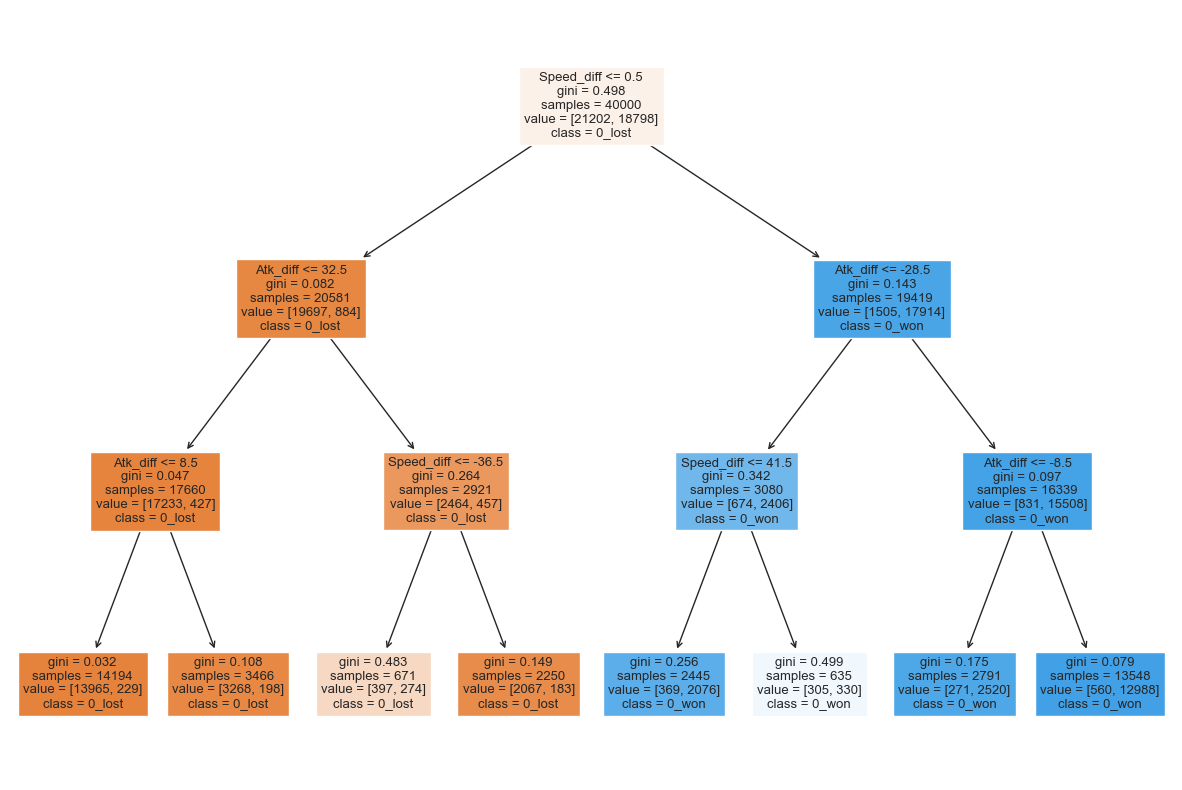

In [41]:
fig = plt.figure(figsize=(15,10))
thing = tree.plot_tree(treeclf,
                       feature_names=feature_cols,
                       class_names=['0_lost', '0_won'],
                       filled=True)

In [42]:
print(f'Score on training set: {treeclf.score(X_train, y_train)}')
print(f'Score on testing set: {treeclf.score(X_test, y_test)}')
##some summary statistics on test and train sets respectively


Score on training set: 0.940275
Score on testing set: 0.9416


In [608]:
from sklearn import metrics

In [609]:
apr(treeclf.predict(X_test), y_test)

Accuracy:0.9416
Precision:0.9291963377416074
Recall:0.950864043306267
F1:0.9399053303148796


(0.9416, 0.9291963377416074, 0.950864043306267, 0.9399053303148796)

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [46]:
##cross validation
scores = cross_val_score(treeclf, X_train, y_train, cv = 5)
sum(scores) / len(scores)


0.9399000000000001

In [ ]:
##SAME APPROACH AS ABOVE, EXCEPT USING NEW 'SUPER' COLUMNS DEFINED TOWARDS END OF CLEANING & MODELLING

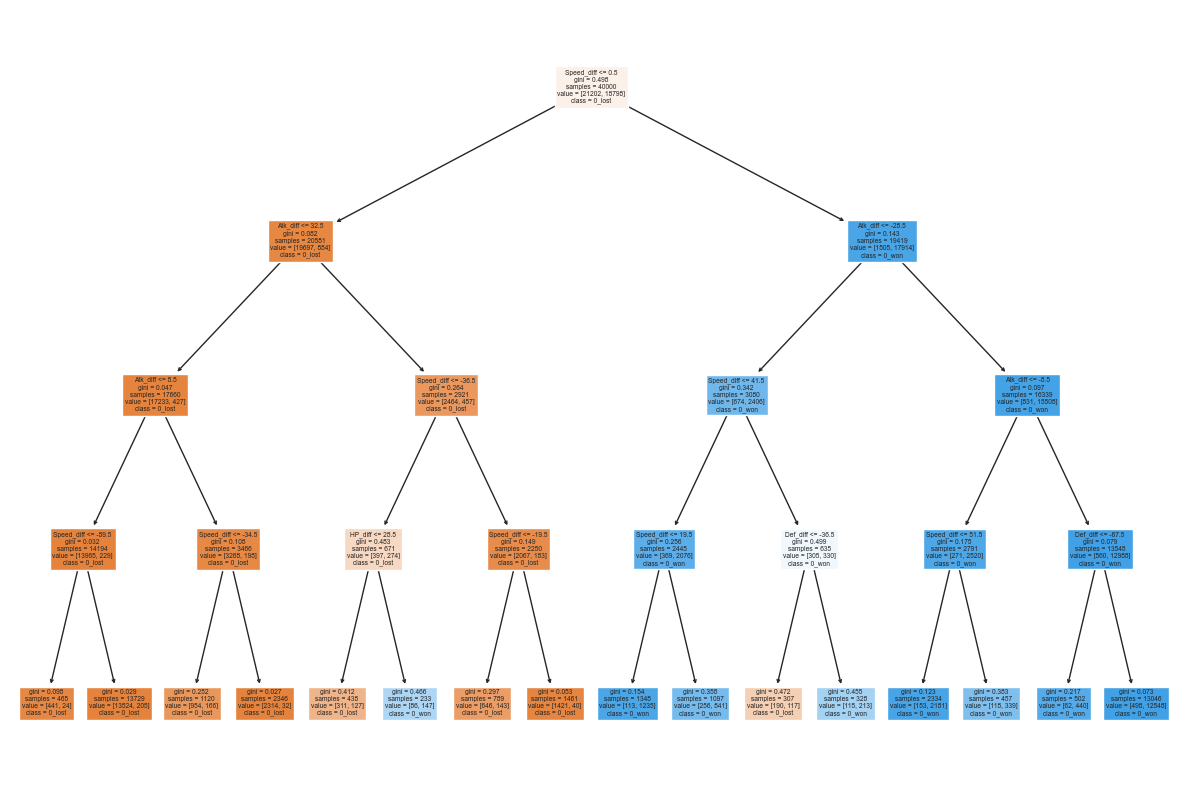

In [338]:
feature_cols_2 = ['HP_diff', 'Atk_diff', 'Def_diff', 'Speed_diff', 'SpAtk_diff', 'SpDef_diff', '0_Super', '1_Super']
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['first_winner?'], test_size = 0.2, random_state = 42)
treeclf2 = DecisionTreeClassifier(max_depth=4, random_state=1)
treeclf2.fit(X_train, y_train)
##fitting decision tree as expected, max depth here chosen arbitrarily and feature engineering used from above for now
fig = plt.figure(figsize=(15,10))
thing = tree.plot_tree(treeclf2,
                       feature_names=feature_cols_2,
                       class_names=['0_lost', '0_won'],
                       filled=True)

In [289]:
print(f'Score on training set: {treeclf2.score(X_train, y_train)}')
print(f'Score on testing set: {treeclf2.score(X_test, y_test)}')
##results have improved slightly (note I included an extra layer to the tree but the results were still improved with only 3) despite not actually utilising the new columns in the tree. Results are still excellent.

Score on training set: 0.943625
Score on testing set: 0.9425


0.9669814232822465


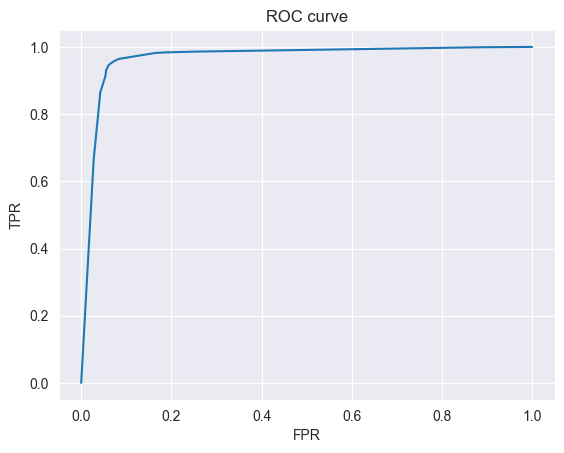

In [343]:
##plotting ROC curve and finding AUROC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

predictions1 = treeclf2.predict_proba(X_test)

print(roc_auc_score(y_test, predictions1[:,1]))

fpr, tpr, _ = roc_curve(y_test, predictions1[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Random Forests attempt 1

In [ ]:
##using feature_cols_2 (including super effective columns) for reason that this improved decision tree results slightly.
from time import time
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

##function for checking accuracy of model
def apr(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)

    print(f"Accuracy:{accuracy}")
    print(f"Precision:{precision}")
    print(f"Recall:{recall}")
    print(f"F1:{f1}")
    return accuracy, precision, recall, f1

In [294]:
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['first_winner?'], test_size = 0.2, random_state = 42)

rf = RandomForestClassifier(n_estimators=100)
et = ExtraTreesClassifier(n_estimators=100)

##rudimentary RF and ET attempt as expected

rf_score = cross_val_score(rf, X_train, y_train, cv=5)
et_score = cross_val_score(et, X_train, y_train, cv=5)
##

print(f'Random scored {rf_score}')
print(f'Extra Random scored {et_score}')
##ever so slightly than individual decision tree (note -- still need to try on test data)

Random scored [0.946875 0.948    0.94825  0.949    0.944875]
Extra Random scored [0.9435   0.946375 0.947375 0.945875 0.942   ]


In [293]:
##investigating best parameters for random forest

rf_params = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 1, 2, 3, 4, 5],
}


gs = GridSearchCV(rf, param_grid=rf_params, cv=5)

gs.fit(X_train, y_train)

print(gs.best_score_)

gs.best_params_

0.9478250000000001


{'max_depth': None, 'n_estimators': 100}

In [296]:
gs.score(X_test, y_test)
##very good score on test data.

0.9494

In [610]:
apr(gs.predict(X_test), y_test)

Accuracy:0.9494
Precision:0.9412610392277675
Recall:0.9541952946075369
F1:0.9476840363937137


(0.9494, 0.9412610392277675, 0.9541952946075369, 0.9476840363937137)

In [611]:
get_results(y_test, gs.predict(X_test))

The confusion matrix for your predictions is:
[[4911  220]
 [ 286 4583]] 

The accuracy of your model is: 0.9494
The recall of your model is: 0.9412610392277675
The precision of your model is: 0.9541952946075369
The f1 of your model is: 0.9476840363937137


# Example Deliverable (Using Decision Tree)

In [47]:
pokemon = pd.read_csv('pokemon.csv')
##reading in pokemon database to be able to read pokemon ids
pokemon['Name'].fillna('Primeape', inplace=True)
##fixing null value (as seen in exploratory notebook)

In [220]:
##function using decision tree defined above to predict the outcome of a 1vs1 battle between pokemon
##NOTE: THIS VERSION WITHOUT PROBABILITY
def battle(poke_1, poke_2):
    ##initialise new dataframe
    print(pokemon[pokemon['#'] == poke_1]['Name'].values[0], 'vs', pokemon[pokemon['#'] == poke_2]['Name'].values[0])
    if poke_1 == poke_2:
        print("Please enter two different pokemon")
        return
    df_battle = pd.DataFrame()
    df_battle = pd.DataFrame(columns=['0_HP', '0_Attack', '0_Defense', '0_Sp. Atk', '0_Sp. Def', '0_Speed', '1_HP', '1_Attack', '1_Defense', '1_Sp. Atk', '1_Sp. Def', '1_Speed'])
    ##set columns to form seen in battle databse
    df_battle.loc['0'] = [pokemon[pokemon['#'] == poke_1]['HP'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Attack'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Defense'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Sp. Atk'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Sp. Def'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Speed'][poke_1 - 1], pokemon[pokemon['#'] == poke_2]['HP'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Attack'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Defense'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Sp. Atk'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Sp. Def'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Speed'][poke_2 - 1]]
    ##input data taken from the id #'s of the two chosen pokemon
    df_battle['HP_diff'] = df_battle['0_HP'] - df_battle['1_HP']
    df_battle['Atk_diff'] = df_battle['0_Attack'] - df_battle['1_Attack']
    df_battle['Def_diff'] = df_battle['0_Defense'] - df_battle['1_Defense']
    df_battle['Speed_diff'] = df_battle['0_Speed'] - df_battle['1_Speed']
    df_battle['SpAtk_diff'] = df_battle['0_Sp. Atk'] - df_battle['1_Sp. Atk']
    df_battle['SpDef_diff'] = df_battle['0_Sp. Def'] - df_battle['1_Sp. Def']
    ##forming differences in values as before such that the values can be passed to the model
    prediction = treeclf.predict(df_battle[feature_cols])
    if prediction == 1:
        print(pokemon[pokemon['#'] == poke_1]['Name'][poke_1 - 1], 'is the winner!')
    else:
        print(pokemon[pokemon['#'] == poke_2]['Name'][poke_2 - 1], 'is the winner!')
    ##returning result based on prediction found

In [221]:
battle(7, 53)
##functions works as expected :)

Charizard vs Parasect
Charizard is the winner!


In [246]:
##function using decision tree defined above to predict the probability of the outcome of a 1vs1 battle between pokemon
##NOTE: THIS VERSION INCLUDING PROBABILITY
def battle_prob(poke_1, poke_2):
    ##initialise new dataframe
    print(pokemon[pokemon['#'] == poke_1]['Name'].values[0], 'vs', pokemon[pokemon['#'] == poke_2]['Name'].values[0])
    if poke_1 == poke_2:
        print("Please enter two different pokemon")
        return
    df_battle = pd.DataFrame()
    df_battle = pd.DataFrame(columns=['0_HP', '0_Attack', '0_Defense', '0_Sp. Atk', '0_Sp. Def', '0_Speed', '1_HP', '1_Attack', '1_Defense', '1_Sp. Atk', '1_Sp. Def', '1_Speed'])
    ##set columns to form seen in battle databse
    df_battle.loc['0'] = [pokemon[pokemon['#'] == poke_1]['HP'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Attack'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Defense'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Sp. Atk'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Sp. Def'][poke_1 - 1], pokemon[pokemon['#'] == poke_1]['Speed'][poke_1 - 1], pokemon[pokemon['#'] == poke_2]['HP'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Attack'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Defense'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Sp. Atk'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Sp. Def'][poke_2 - 1], pokemon[pokemon['#'] == poke_2]['Speed'][poke_2 - 1]]
    ##input data taken from the id #'s of the two chosen pokemon
    df_battle['HP_diff'] = df_battle['0_HP'] - df_battle['1_HP']
    df_battle['Atk_diff'] = df_battle['0_Attack'] - df_battle['1_Attack']
    df_battle['Def_diff'] = df_battle['0_Defense'] - df_battle['1_Defense']
    df_battle['Speed_diff'] = df_battle['0_Speed'] - df_battle['1_Speed']
    df_battle['SpAtk_diff'] = df_battle['0_Sp. Atk'] - df_battle['1_Sp. Atk']
    df_battle['SpDef_diff'] = df_battle['0_Sp. Def'] - df_battle['1_Sp. Def']
    ##forming differences in values as before such that the values can be passed to the model
    prediction = treeclf.predict_proba(df_battle[feature_cols])
    if prediction[0][1] >= 0.5:
        print(pokemon[pokemon['#'] == poke_1]['Name'][poke_1 - 1], 'is the winner with probability', round(prediction[0][1], 2))
    else:
        print(pokemon[pokemon['#'] == poke_2]['Name'][poke_2 - 1], 'is the winner with probability', round(prediction[0][0], 2))
    ##returning predicted result and associated probability

In [247]:
battle_prob(7, 53)
##function works as expected :)

Charizard vs Parasect
Charizard is the winner with probability 0.9


## Refactoring Attempt on above function

In [314]:
##function using decision tree defined above to predict the outcome of a 1vs1 battle between pokemon
##NOTE: THIS VERSION INCLUDING PROBABILITY
##NOTE: CAN REPLACE PROBABILITY AT BOTTOM EASILY WITH THAT OF ANY MODEL USED IN ABOVE SECTION
def battle_prob_2(poke_1, poke_2):
    ##initialise new dataframe
    print(pokemon[pokemon['#'] == poke_1]['Name'].values[0], 'vs', pokemon[pokemon['#'] == poke_2]['Name'].values[0])
    if poke_1 == poke_2:
        print("Please enter two different pokemon")
        return
    df_battle = pd.DataFrame()
    df_battle = pd.DataFrame(columns=['0_HP', '0_Attack', '0_Defense', '0_Sp. Atk', '0_Sp. Def', '0_Speed', '1_HP', '1_Attack', '1_Defense', '1_Sp. Atk', '1_Sp. Def', '1_Speed'])
    ##set columns to form seen in battle databse
    poke_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
    poke_values = [pokemon[pokemon['#'] == poke_1][item].values[0] for item in poke_cols] + [pokemon[pokemon['#'] == poke_2][item].values[0] for item in poke_cols]
    df_battle.loc['0'] = poke_values
    ##input data taken from the id #'s of the two chosen pokemon
    df_battle['HP_diff'] = df_battle['0_HP'] - df_battle['1_HP']
    df_battle['Atk_diff'] = df_battle['0_Attack'] - df_battle['1_Attack']
    df_battle['Def_diff'] = df_battle['0_Defense'] - df_battle['1_Defense']
    df_battle['Speed_diff'] = df_battle['0_Speed'] - df_battle['1_Speed']
    df_battle['SpAtk_diff'] = df_battle['0_Sp. Atk'] - df_battle['1_Sp. Atk']
    df_battle['SpDef_diff'] = df_battle['0_Sp. Def'] - df_battle['1_Sp. Def']
    ##forming differences in values as before such that the values can be passed to the model
    prediction = treeclf.predict_proba(df_battle[feature_cols])
    if prediction[0][1] >= 0.5:
        print(pokemon[pokemon['#'] == poke_1]['Name'].values[0], 'is the winner with probability', round(prediction[0][1], 2))
    else:
        print(pokemon[pokemon['#'] == poke_2]['Name'].values[0], 'is the winner with probability', round(prediction[0][0], 2))

In [ ]:
battle_prob_2(1, 5)

## Same function as above -- using Random Forests this time (slightly improved results)

In [325]:
##function using decision tree defined above to predict the outcome of a 1vs1 battle between pokemon
##NOTE: THIS VERSION INCLUDING PROBABILITY
##NOTE: CAN REPLACE PROBABILITY AT BOTTOM EASILY WITH THAT OF ANY MODEL USED IN ABOVE SECTION
def battle_prob_3(poke_1, poke_2):
    ##initialise new dataframe
    print(pokemon[pokemon['#'] == poke_1]['Name'].values[0], 'vs', pokemon[pokemon['#'] == poke_2]['Name'].values[0])
    if poke_1 == poke_2:
        print("Please enter two different pokemon")
        return
    df_battle = pd.DataFrame()
    df_battle = pd.DataFrame(columns=['0_HP', '0_Attack', '0_Defense', '0_Sp. Atk', '0_Sp. Def', '0_Speed', '1_HP', '1_Attack', '1_Defense', '1_Sp. Atk', '1_Sp. Def', '1_Speed'])
    ##set columns to form seen in battle databse
    poke_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
    poke_values = [pokemon[pokemon['#'] == poke_1][item].values[0] for item in poke_cols] + [pokemon[pokemon['#'] == poke_2][item].values[0] for item in poke_cols]
    df_battle.loc['0'] = poke_values
    ##input data taken from the id #'s of the two chosen pokemon
    df_battle['HP_diff'] = df_battle['0_HP'] - df_battle['1_HP']
    df_battle['Atk_diff'] = df_battle['0_Attack'] - df_battle['1_Attack']
    df_battle['Def_diff'] = df_battle['0_Defense'] - df_battle['1_Defense']
    df_battle['Speed_diff'] = df_battle['0_Speed'] - df_battle['1_Speed']
    df_battle['SpAtk_diff'] = df_battle['0_Sp. Atk'] - df_battle['1_Sp. Atk']
    df_battle['SpDef_diff'] = df_battle['0_Sp. Def'] - df_battle['1_Sp. Def']
    ##forming differences in values as before such that the values can be passed to the model
    prediction = gs.predict_proba(df_battle[feature_cols])
    print(prediction)
    print(prediction[0])
    print(prediction[0][1])
    if prediction[0][1] >= 0.5:
        print(pokemon[pokemon['#'] == poke_1]['Name'].values[0], 'is the winner with probability', round(prediction[0][1], 2))
    else:
        print(pokemon[pokemon['#'] == poke_2]['Name'].values[0], 'is the winner with probability', round(prediction[0][0], 2))

In [337]:
battle_prob_3(163, 362)
##don't like the results from this one so much -- while more accurate generally, the probabilities are more stark.
##multiply probability by accuracy for different metric? -- not sure

Mewtwo vs Flygon
[[0.04 0.96]]
[0.04 0.96]
0.96
Mewtwo is the winner with probability 0.96


## Tournemant Bracket Attempt

In [345]:
##below code is experementation with using pandas dataframes to calculate and store the bracket results

In [405]:
bracket = pd.DataFrame(index=range(0,8),columns=['0', '1', '2', '3', '4', '5', '6', '7', ])

In [406]:
bracket.fillna(' ', inplace=True)
##creating empty dataframe in which to place tournemant results

In [411]:
bracket['0'][0] = 'Charmander'
bracket['0'][2] = 'Bulbasaur'
bracket['0'][4] = 'Squirtle'
bracket['0'][6] = 'Pikachu'
bracket['7'][0] = 'Pokemon'
bracket['7'][2] = 'Pokemon'
bracket['7'][4] = 'Pokemon'
bracket['7'][6] = 'Pokemon'

In [412]:
bracket

,0,1,2,3,4,5,6,7
0,Charmander,,,,,,,Pokemon
1,,,,,,,,
2,Bulbasaur,,,,,,,Pokemon
3,,,,,,,,
4,Squirtle,,,,,,,Pokemon
5,,,,,,,,
6,Pikachu,,,,,,,Pokemon
7,,,,,,,,


In [415]:
def poke_to_id(name):
    return pokemon[pokemon['Name'] == name]['#'].values[0]
##function to take the name of a pokemon and return its id

In [421]:
var1, var2 = battle_prob_2_bracket(poke_to_id(bracket['0'][0]), poke_to_id(bracket['0'][2]))

In [548]:
## function to set up and run the bracket system
##NOTE -- NEEDS REFACTORING

def bracket(pk1, pk2, pk3, pk4, pk5, pk6, pk7, pk8):
    import random
    poke_list = [pk1, pk2, pk3, pk4, pk5, pk6, pk7, pk8]
    #random.shuffle(poke_list) ##note -- this function applies itself automatically >:|
    bracket_df = pd.DataFrame(index=range(0,8),columns=['0', '1', '2', '3', '4', '5', '6'])
    bracket_df.fillna(' ', inplace=True)
    ###section of function which actually runs battles and produces dataframe of results
    for i in range(4):
        bracket_df['0'][i*2] = poke_list[i]
        bracket_df['6'][i*2] = poke_list[i+4]
    for j in range(2):
        bracket_df['1'][j*4 + 1] = battle_prob_2_bracket(poke_to_id(bracket_df['0'][j*4]), poke_to_id(bracket_df['0'][j*4 + 2]))[0]
        bracket_df['1'][j*4 + 2] = battle_prob_2_bracket(poke_to_id(bracket_df['0'][j*4]), poke_to_id(bracket_df['0'][j*4 + 2]))[1]
        bracket_df['5'][j*4 + 1] = battle_prob_2_bracket(poke_to_id(bracket_df['6'][j*4]), poke_to_id(bracket_df['6'][j*4 + 2]))[0]
        bracket_df['5'][j*4 + 2] = battle_prob_2_bracket(poke_to_id(bracket_df['6'][j*4]), poke_to_id(bracket_df['6'][j*4 + 2]))[1]

    bracket_df['2'][3] = battle_prob_2_bracket(poke_to_id(bracket_df['1'][1]), poke_to_id(bracket_df['1'][5]))[0]
    bracket_df['2'][4] = battle_prob_2_bracket(poke_to_id(bracket_df['1'][1]), poke_to_id(bracket_df['1'][5]))[1]
    bracket_df['4'][3] = battle_prob_2_bracket(poke_to_id(bracket_df['5'][1]), poke_to_id(bracket_df['5'][5]))[0]
    bracket_df['4'][4] = battle_prob_2_bracket(poke_to_id(bracket_df['5'][1]), poke_to_id(bracket_df['5'][5]))[1]

    bracket_df['3'][2] = battle_prob_2_bracket(poke_to_id(bracket_df['2'][3]), poke_to_id(bracket_df['4'][3]))[0]
    bracket_df['3'][3] = battle_prob_2_bracket(poke_to_id(bracket_df['2'][3]), poke_to_id(bracket_df['4'][3]))[1]
    ###
    ###
    ###section of function to check how our results compared to real battles
    pair_1 = [bracket_df['0'][0], bracket_df['0'][2], bracket_df['1'][1]]
    pair_2 = [bracket_df['0'][4], bracket_df['0'][6], bracket_df['1'][5]]
    pair_3 = [bracket_df['6'][0], bracket_df['6'][2], bracket_df['5'][1]]
    pair_4 = [bracket_df['6'][4], bracket_df['6'][6], bracket_df['5'][5]]
    pair_5 = [bracket_df['1'][1], bracket_df['1'][5], bracket_df['2'][3]]
    pair_6 = [bracket_df['5'][1], bracket_df['5'][5], bracket_df['4'][3]]
    pair_7 = [bracket_df['2'][3], bracket_df['4'][3], bracket_df['3'][2]]
    pairs = [pair_1, pair_2, pair_3, pair_4, pair_5, pair_6, pair_7,]
    correct = 0
    total = 0
    for item in pairs:
        if len(df[df['First_pokemon'] == poke_to_id(item[0])][df['Second_pokemon'] == poke_to_id(item[1])]) != 0:
            total += 1
            if df[df['First_pokemon'] == poke_to_id(item[0])][df['Second_pokemon'] == poke_to_id(item[1])]['Winner'].values[0] == poke_to_id(item[2]):
                correct += 1
    if total != 0:
        print(total, 'of these battles happened in the original data!')
        print(correct, 'such battles were predicted correctly, for an accuracy of', correct/total )
    return bracket_df

In [550]:
import warnings
warnings.filterwarnings("ignore")

In [551]:
testing = bracket('Nuzleaf', 'Machop', 'Squirtle', 'Turtwig', 'Piplup', 'Chimchar', 'Ekans', 'Rapidash')
##function works as expected (see results below)

1 of these battles happened in the original data!
1 such battles were predicted correctly, for an accuracy of 1.0


In [552]:
testing

,0,1,2,3,4,5,6
0,Nuzleaf,,,,,,Piplup
1,,Nuzleaf,,,,Chimchar,
2,Machop,0.9,,Rapidash,,0.98,Chimchar
3,,,Nuzleaf,0.98,Rapidash,,
4,Squirtle,,0.96,,0.98,,Ekans
5,,Squirtle,,,,Rapidash,
6,Turtwig,0.9,,,,0.98,Rapidash
7,,,,,,,


In [ ]:
###below function is final version used in bracket system

In [460]:
##function using decision tree defined above to predict the outcome of a 1vs1 battle between pokemon
##NOTE: THIS VERSION INCLUDING PROBABILITY
##NOTE: CAN REPLACE PROBABILITY AT BOTTOM EASILY WITH THAT OF ANY MODEL USED IN ABOVE SECTION
##NOTE: VARIATION OF FUNCTION TO BE USED IN BRACKET -- RETURNS NAME OF WINNING POKEMON
def battle_prob_2_bracket(poke_1, poke_2):
    ##initialise new dataframe
    if poke_1 == poke_2:
        print("Please enter two different pokemon")
        return
    df_battle = pd.DataFrame()
    df_battle = pd.DataFrame(columns=['0_HP', '0_Attack', '0_Defense', '0_Sp. Atk', '0_Sp. Def', '0_Speed', '1_HP', '1_Attack', '1_Defense', '1_Sp. Atk', '1_Sp. Def', '1_Speed'])
    ##set columns to form seen in battle databse
    poke_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
    poke_values = [pokemon[pokemon['#'] == poke_1][item].values[0] for item in poke_cols] + [pokemon[pokemon['#'] == poke_2][item].values[0] for item in poke_cols]
    df_battle.loc['0'] = poke_values
    ##input data taken from the id #'s of the two chosen pokemon
    df_battle['HP_diff'] = df_battle['0_HP'] - df_battle['1_HP']
    df_battle['Atk_diff'] = df_battle['0_Attack'] - df_battle['1_Attack']
    df_battle['Def_diff'] = df_battle['0_Defense'] - df_battle['1_Defense']
    df_battle['Speed_diff'] = df_battle['0_Speed'] - df_battle['1_Speed']
    df_battle['SpAtk_diff'] = df_battle['0_Sp. Atk'] - df_battle['1_Sp. Atk']
    df_battle['SpDef_diff'] = df_battle['0_Sp. Def'] - df_battle['1_Sp. Def']
    ##forming differences in values as before such that the values can be passed to the model
    prediction = treeclf.predict_proba(df_battle[feature_cols])
    if prediction[0][1] >= 0.5:
        return pokemon[pokemon['#'] == poke_1]['Name'].values[0], round(prediction[0][1], 2)
    else:
        return pokemon[pokemon['#'] == poke_2]['Name'].values[0], round(prediction[0][0], 2)

In [593]:
import random
names_test = random.sample(list(pokemon['Name']), 8)
##generating random sample of pokemon

In [ ]:
bracket(names_test[0], names_test[1], names_test[2], names_test[3], names_test[4], names_test[5], names_test[6], names_test[7])
##testing bracket function using random list generated above

In [ ]:
###note -- below tests were used in demo during presentation and can be ignored

In [662]:
import random
names_test = random.sample(list(pokemon['Name']), 8)

In [663]:
bracket('Charmander', 'Sylveon', 'Snorlax', 'Dialga', names_test[4], names_test[5], names_test[6], names_test[7])

,0,1,2,3,4,5,6
0,Charmander,,,,,,Tyrunt
1,,Charmander,,,,Hitmontop,
2,Sylveon,0.9,,Dialga,,0.98,Hitmontop
3,,,Dialga,0.96,Nidoking,,
4,Snorlax,,0.98,,0.98,,Cascoon
5,,Dialga,,,,Nidoking,
6,Dialga,0.98,,,,0.98,Nidoking
7,,,,,,,


In [655]:
import random
names_test = random.sample(list(pokemon['Name']), 8)

In [ ]:
bracket(names_test[0], names_test[1], names_test[2], names_test[3], names_test[4], names_test[5], names_test[6], names_test[7])